# Basic usage

The command line interface `python -m autora.workflow` allows us to load and save `States` and run arbitrary 
functions on them.

In [ ]:
%cat lib.py

import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression

from autora.experimentalist.grid import grid_pool
from autora.state import StandardState, estimator_on_state, on_state
from autora.variable import Variable, VariableCollection
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures

rng = np.random.default_rng()


def initial_state(_):
    state = StandardState(
        variables=VariableCollection(
            independent_variables=[
                Variable(name="x", allowed_values=np.linspace(-10, +10, 1001))
            ],
            dependent_variables=[Variable(name="y")],
            covariates=[],
        ),
        conditions=None,
        experiment_data=pd.DataFrame({"x": [], "y": []}),
        models=[],
    )
    return state


@on_state(output=["conditions"])
def experimentalist(variables):
    conditions: pd.DataFrame = grid_pool(variables)
   

We can run the pipeline of initialization, condition generation, experiment and theory building as follows.

First we create an initial state file:  

In [ ]:
!python -m autora.workflow lib.initial_state --out-path initial.pkl

Next we run the condition generation:

In [ ]:
!python -m autora.workflow lib.experimentalist --in-path initial.pkl --out-path conditions.pkl

We run the experiment:

In [ ]:
!python -m autora.workflow lib.experiment_runner --in-path conditions.pkl --out-path experiment_data.pkl

And then the theorist:

In [ ]:
!python -m autora.workflow lib.theorist --in-path experiment_data.pkl --out-path model.pkl

We can interrogate the results by loading them into the current session.

In [ ]:
from autora.workflow.__main__ import load_state
s = load_state("model.pkl")
s

StandardState(variables=VariableCollection(independent_variables=[Variable(name='x', value_range=None, allowed_values=array([-10.  ,  -9.98,  -9.96, ...,   9.96,   9.98,  10.  ]), units='', type=<ValueType.REAL: 'real'>, variable_label='', rescale=1, is_covariate=False)], dependent_variables=[Variable(name='y', value_range=None, allowed_values=None, units='', type=<ValueType.REAL: 'real'>, variable_label='', rescale=1, is_covariate=False)], covariates=[]), conditions=        x
342 -3.16
869  7.38
732  4.64
387 -2.26
919  8.38
949  8.98
539  0.78
563  1.26
855  7.10
772  5.44, experiment_data=      x           y
0 -3.16    1.257587
1  7.38  153.259915
2  4.64   54.291348
3 -2.26   10.374509
4  8.38  155.483778
5  8.98  183.774472
6  0.78    3.154024
7  1.26   14.033608
8  7.10  103.032008
9  5.44   94.629911, models=[GridSearchCV(estimator=Pipeline(steps=[('polynomialfeatures',
                                        PolynomialFeatures()),
                                       ('linear

We have three new fields in the state. The first is the conditions, a sample of ten values from between -10 and 10.

In [ ]:
s.conditions

,x
342,-3.16
869,7.38
732,4.64
387,-2.26
919,8.38
949,8.98
539,0.78
563,1.26
855,7.10
772,5.44


We have experiment data corresponding to those conditions:

In [ ]:
s.experiment_data

,x,y
0,-3.16,1.257587
1,7.38,153.259915
2,4.64,54.291348
3,-2.26,10.374509
4,8.38,155.483778
5,8.98,183.774472
6,0.78,3.154024
7,1.26,14.033608
8,7.10,103.032008
9,5.44,94.629911


We have a best-fit linear model.

In [ ]:
s.model

GridSearchCV(estimator=Pipeline(steps=[('polynomialfeatures',
                                        PolynomialFeatures()),
                                       ('linearregression',
                                        LinearRegression())]),
             param_grid={'polynomialfeatures__degree': [0, 1, 2, 3, 4]},
             scoring='r2')

... which we can plot:

/Users/jholla10/Developer/autora-workflow/.venv/lib/python3.8/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


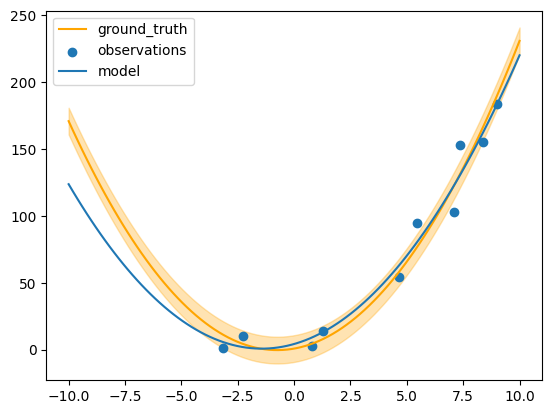

In [ ]:
import numpy as np
from matplotlib import pyplot as plt

from lib import ground_truth, noise_std

def plot_results(state):
    x = np.linspace(-10, 10, 100).reshape((-1, 1))
    plt.plot(x, ground_truth(x), label="ground_truth", c="orange")
    plt.fill_between(x.flatten(), ground_truth(x).flatten() + noise_std, ground_truth(x).flatten() - noise_std,
                     alpha=0.3, color="orange")
    
    xi, yi = state.experiment_data["x"], state.experiment_data["y"]
    plt.scatter(xi, yi, label=f"observations")
    
    plt.plot(x, state.model.predict(x), label="model")
    
    plt.legend()

plot_results(s)

If we run the experiment for another 3 cycles, we can get results closer to the ground truth. In this example, we overwrite the results file each time the CLI is called.

In [ ]:
!cp "model.pkl" "result.pkl"
for i in range(3):
    !python -m autora.workflow lib.experimentalist --in-path "result.pkl" --out-path "result.pkl"
    !python -m autora.workflow lib.experiment_runner --in-path "result.pkl" --out-path "result.pkl"
    !python -m autora.workflow lib.theorist --in-path "result.pkl" --out-path "result.pkl"


/Users/jholla10/Developer/autora-workflow/.venv/lib/python3.8/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


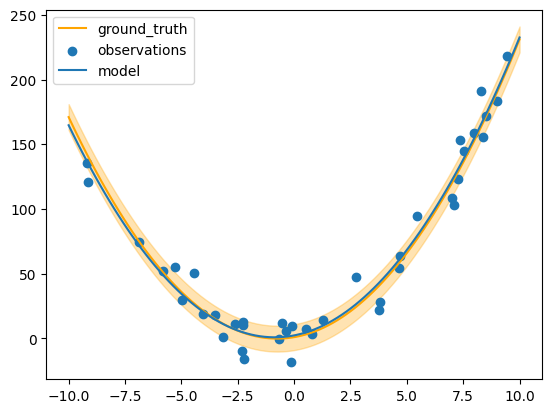

In [ ]:
state_after_three_more_cycles = load_state("result.pkl")
plot_results(state_after_three_more_cycles)

We can continue to run for as long as we like, e.g. another 10 cycles:

/Users/jholla10/Developer/autora-workflow/.venv/lib/python3.8/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


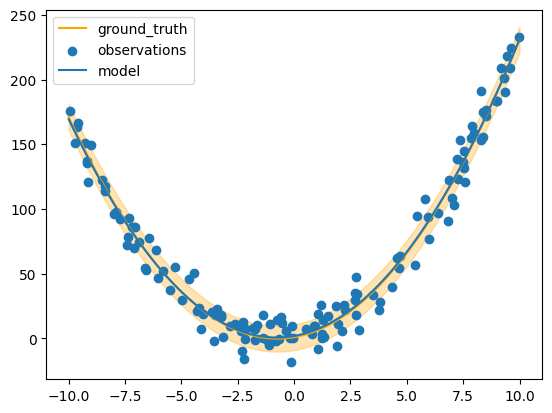

In [ ]:
!cp "result.pkl" "result-10.pkl"
for i in range(10):
    !python -m autora.workflow lib.experimentalist --in-path "result-10.pkl" --out-path "result-10.pkl"
    !python -m autora.workflow lib.experiment_runner --in-path "result-10.pkl" --out-path "result-10.pkl"
    !python -m autora.workflow lib.theorist --in-path "result-10.pkl" --out-path "result-10.pkl"

state_after_ten_more_cycles = load_state("result-10.pkl")

plot_results(state_after_ten_more_cycles)